# Load libraries

In [1]:
import os
import numpy as np
import pandas as pd
import copy

#import cupy
import dask

import ase
from ase.visualize import view

import abtem

import matplotlib.pyplot as plt

### Configure GPU setting when using two GPUs

### Configure GPU setting when using one GPU

abtem.config.set({"device": "gpu"});
dask.config.set({"num_workers": 1});
abtem.config.set({"dask.chunk-size-gpu" : "2048 MB"})

# Change default figure size

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

# Read simulation cells

In [3]:
folder = r"C:\Users\maryam\Desktop\abtem"

files = [i for i in os.listdir(folder) if i.endswith(".cif")]
cells = [os.path.join(folder, i) for i in files]
cells
pd.DataFrame(files, columns=['simulation cells'])

,simulation cells
0,MnSbTe.cif
1,MnSbTe_scaled.cif


# Select cell index and read

In [4]:
from ase.io import read

cell_ind = 0

atoms = read(r"C:\Users\maryam\Desktop\abtem\\MnSbTe.cif")
atoms.rotate(-90,'x',center=(0.5,0.5,0.5))

In [5]:
## Rotate cell around x to swap y and z
#atoms.rotate(90, 'y', rotate_cell=True)
#atoms.rotate(90, 'x', rotate_cell=True)

# Determine slice thickness
eps = 0.1
atoms_pos = atoms.get_positions()
atoms_z = atoms_pos[:,2]
atoms_z_min = np.min(atoms_z[atoms_z>eps])

slice_thickness = round(atoms_z_min,3)
print('Slice thickness in Angstrom:', slice_thickness)

Slice thickness in Angstrom: 1.0


# Display simulation cell with ASE

(<Figure size 2000x2000 with 2 Axes>, <Axes: xlabel='y [Å]', ylabel='z [Å]'>)

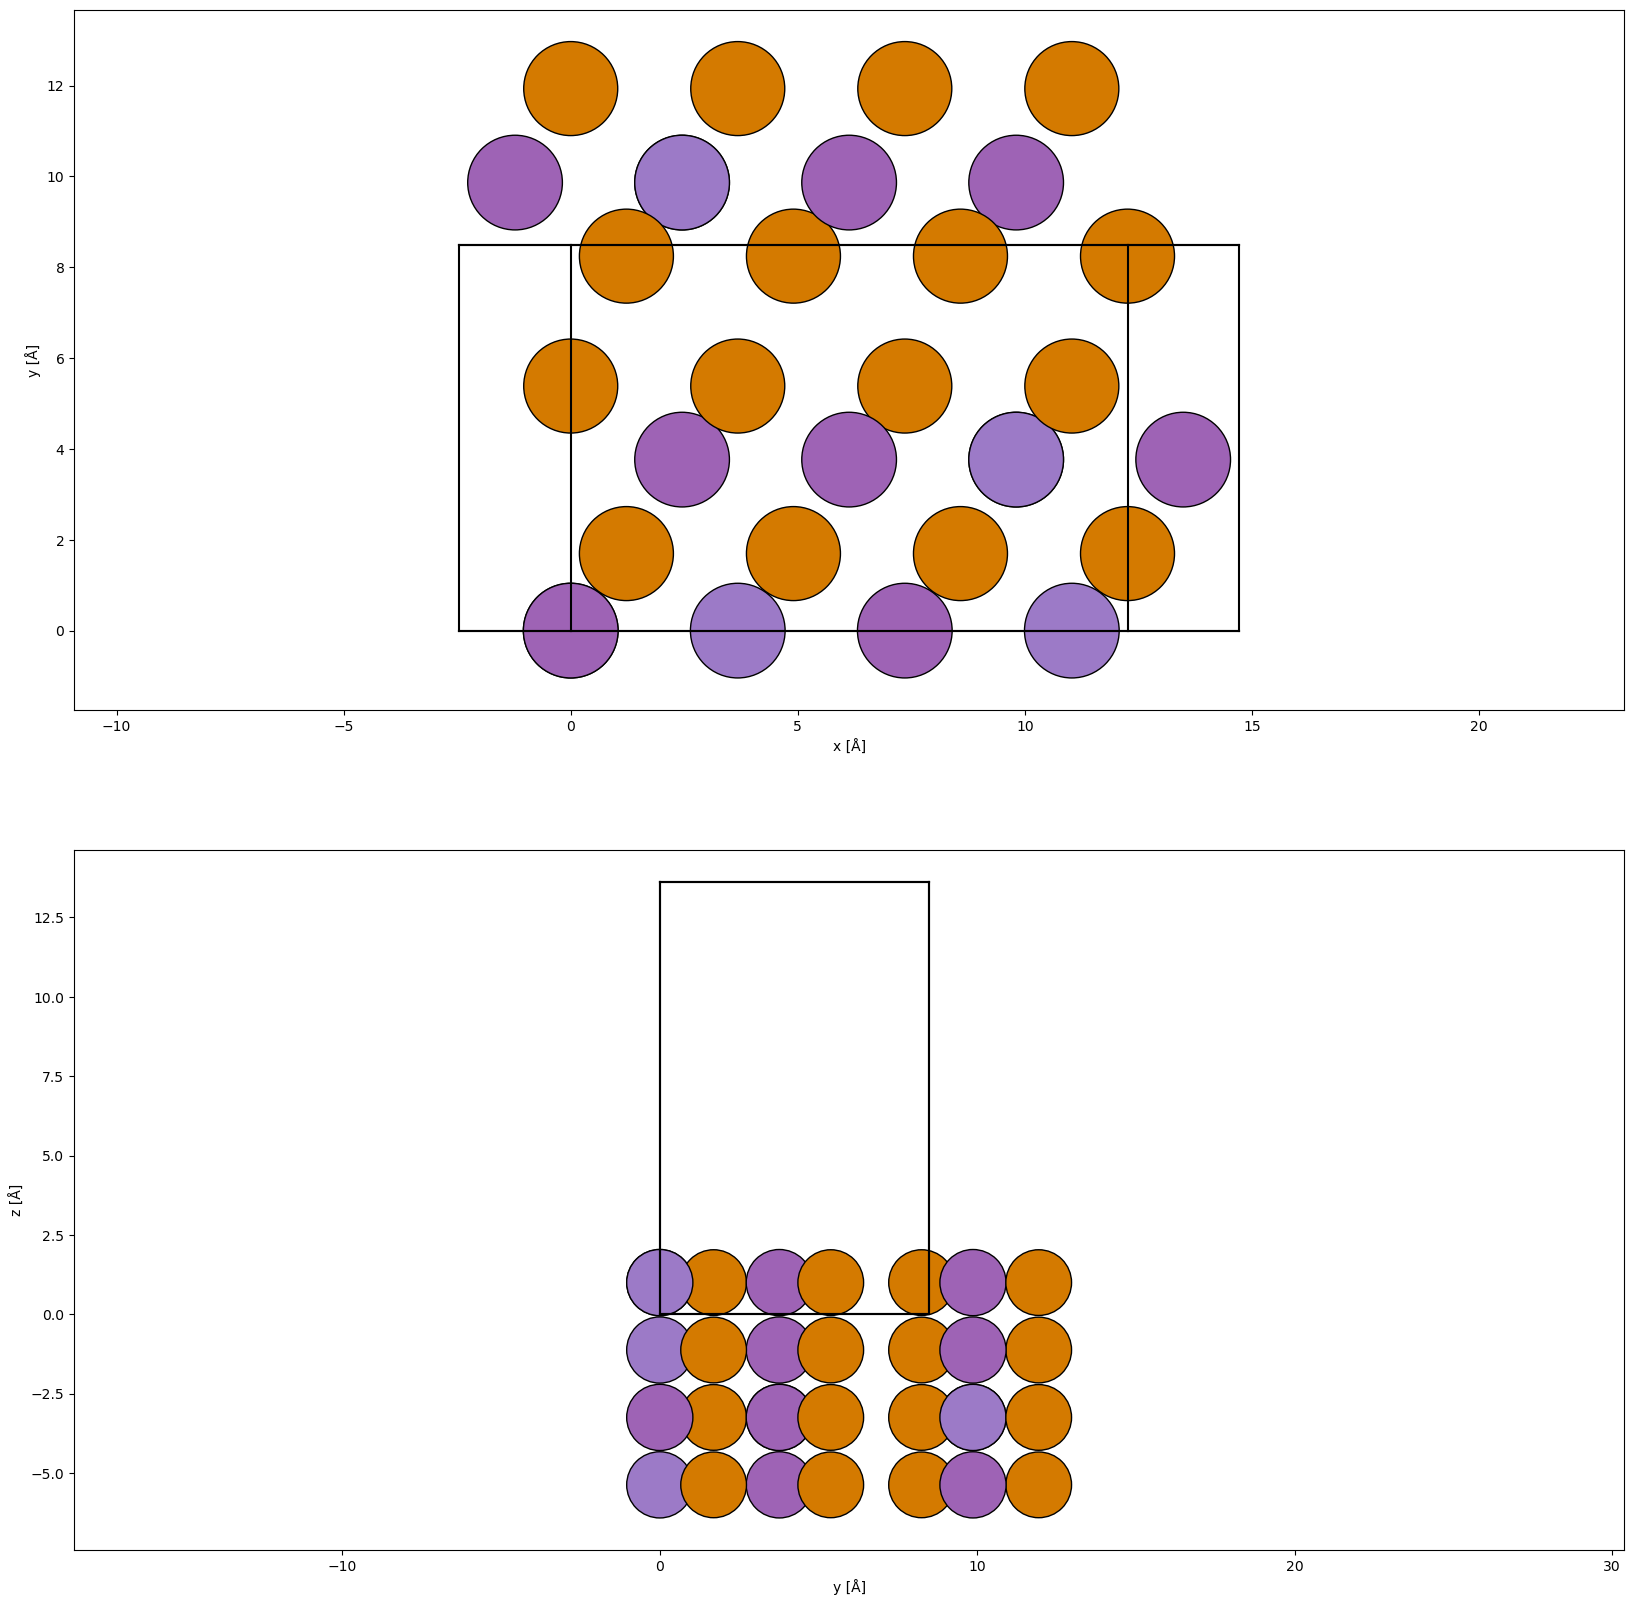

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
abtem.show_atoms(atoms, plane='xy', ax=ax1)
abtem.show_atoms(atoms, plane='yz', ax=ax2)

### Replicate simulation cell along z-direction

Cell thickness in Angstrom: 50.892711510212564
Number of slices: 5


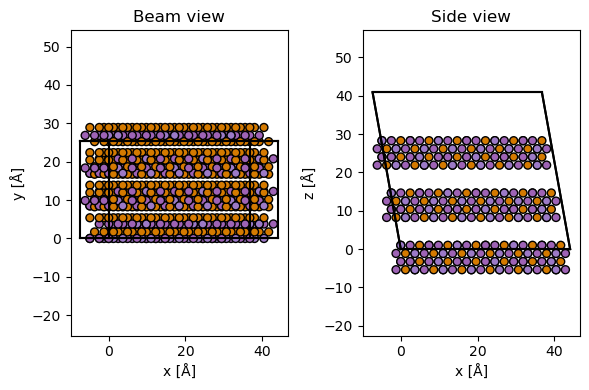

In [7]:
# Select on how many unit cells to stack
# The z direction corresponds to the direction of the electron beam
num_stacks_xy = 3
num_stacks_z = 3
slice_thickness=10

atoms_stack = copy.deepcopy(atoms)
atoms_stack = atoms_stack * (num_stacks_xy, num_stacks_xy, num_stacks_z)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
abtem.show_atoms(atoms_stack, ax=ax1, title="Beam view")
abtem.show_atoms(atoms_stack, ax=ax2, plane="xz", title="Side view")
fig.tight_layout();

cell_thickness = atoms_stack.get_cell()[2][2] + slice_thickness
print('Cell thickness in Angstrom:', cell_thickness)

number_slices = int(round(cell_thickness / slice_thickness, 0))
print('Number of slices:', number_slices)


#orthogonalized_atoms = abtem.orthogonalize_cell(atoms)


# Orthorgonalize cell

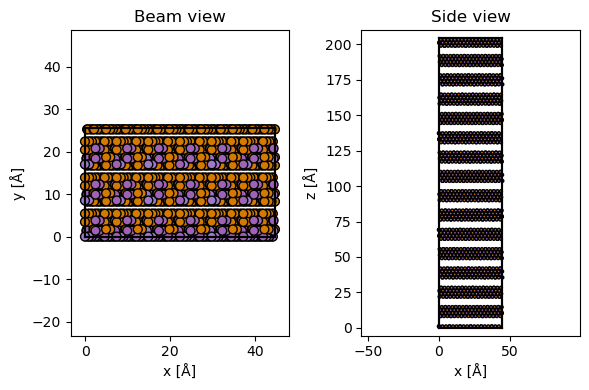

In [8]:
atoms_stack = abtem.orthogonalize_cell(atoms_stack, return_transform=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
abtem.show_atoms(atoms_stack, ax=ax1, title="Beam view")
abtem.show_atoms(atoms_stack, ax=ax2, plane="xz", title="Side view")
fig.tight_layout();

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>)

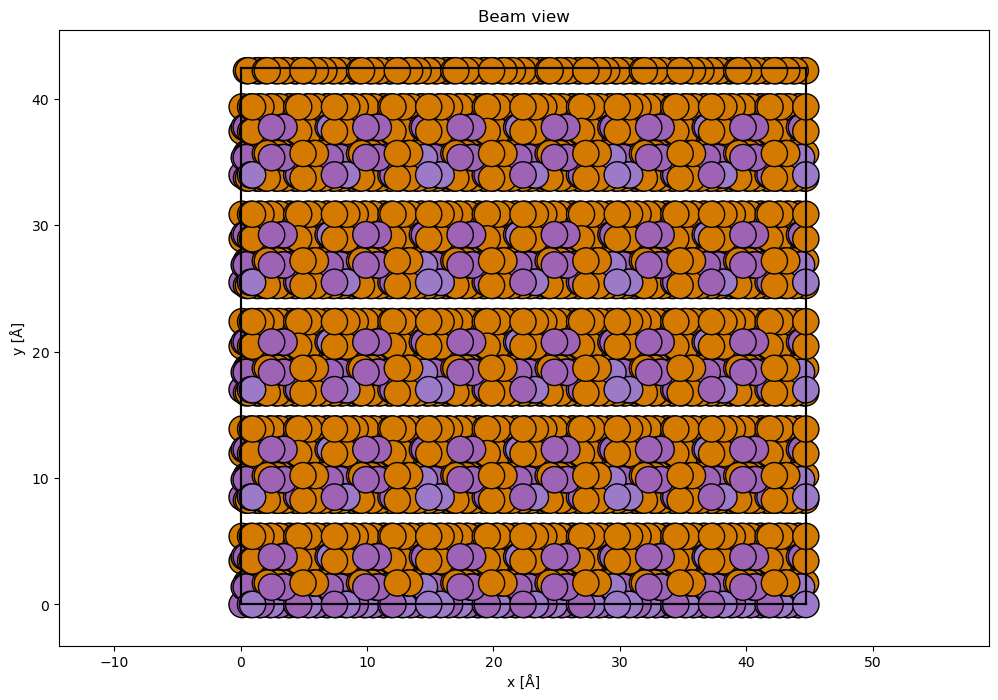

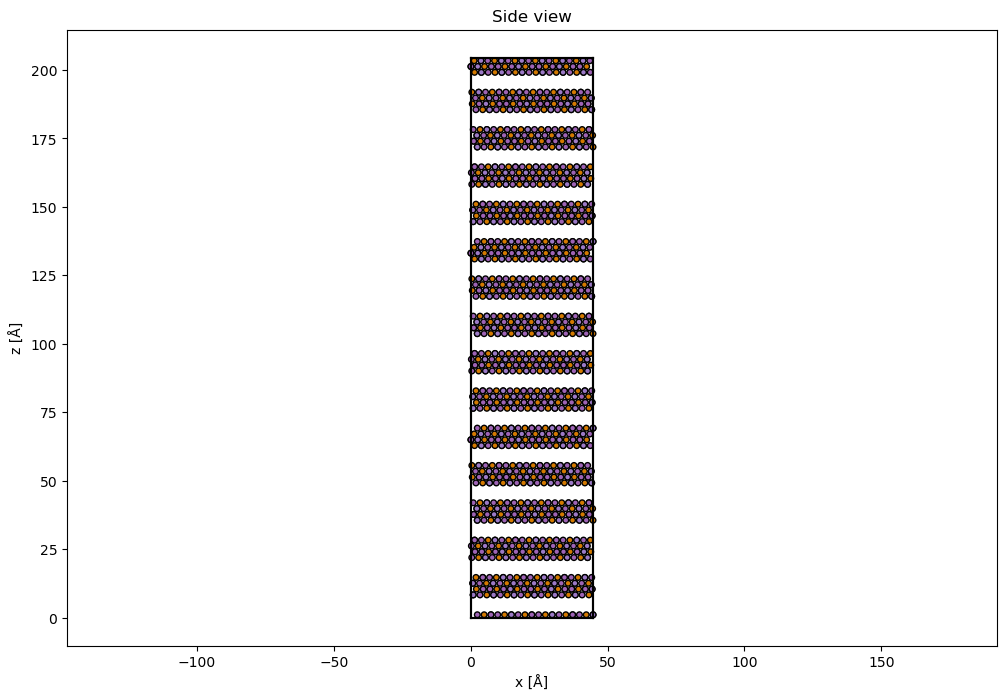

In [9]:
import abtem 
orthogonalized_atoms = abtem.orthogonalize_cell(atoms)
atoms=orthogonalized_atoms.repeat((3,5,3))
abtem.show_atoms(atoms, plane="xy", title="Beam view")
abtem.show_atoms(atoms, plane="xz", title="Side view")

In [10]:
import numpy as np

# lengths of the orthogonal cell (Å)
ax, ay, az = atoms.get_cell().lengths()
print(f"Lateral size: ax = {ax:.2f} Å, ay = {ay:.2f} Å")
print(f"Thickness (z): thickness = {az:.2f} Å")
print(f"Number of atoms: {len(atoms)}")

slice_thickness = 1.0
n_slices = int(np.round(az / slice_thickness))
print(f"Suggested number of slices (@ {slice_thickness:.2f} Å): {n_slices}")

Lateral size: ax = 44.75 Å, ay = 42.47 Å
Thickness (z): thickness = 204.46 Å
Number of atoms: 12600
Suggested number of slices (@ 1.00 Å): 204


In [11]:
#ax is good  ay is small   
#200kev a=28.79mrad   diameter of probe 0.1A        x y 20-30A
#y  3, 2   z 2,3,15

In [12]:
ax, ay, az = atoms.get_cell().lengths()
print(f"Lateral size: ax={ax:.1f} Å, ay={ay:.1f} Å, Thickness: az={az:.1f} Å")
print(f"Number of atoms: {len(atoms)}")

Lateral size: ax=44.7 Å, ay=42.5 Å, Thickness: az=204.5 Å
Number of atoms: 12600


# Compute projected potential

### Select thickness increment in number of slices to output during the simulation

In [13]:
print('Cell thickness in Angstrom:', cell_thickness)
print('Slice thickness in Angstrom:', slice_thickness)
print('Number of slices:', number_slices)

Cell thickness in Angstrom: 50.892711510212564
Slice thickness in Angstrom: 1.0
Number of slices: 5


In [14]:
thickness_increment = 24
print('Output of exit waves every:', round(thickness_increment*slice_thickness,3)
      , 'Angstrom')
print('Leads to an array with around', 
      int(np.ceil(cell_thickness/(thickness_increment*slice_thickness)+1))
      ,'layers along the beam direction')

Output of exit waves every: 24.0 Angstrom
Leads to an array with around 4 layers along the beam direction


### Compute projected potentials including frozen phonon configurations

[########################################] | 100% Completed | 159.29 s


(10, 205, 895, 850)

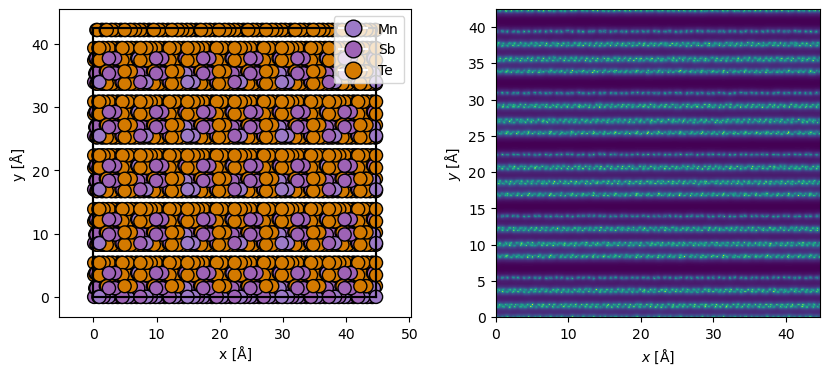

In [15]:
frozen_phonons = abtem.FrozenPhonons(atoms, num_configs=10, sigmas=0.1, seed=100)

# Compute the projected potential
projected_potential_phonons = abtem.Potential(frozen_phonons, sampling=0.05, 
                                        slice_thickness=slice_thickness, 
                                        projection='infinite', 
                                        parametrization='lobato',
                                        exit_planes=thickness_increment,
                                        device='cpu')
projected_potential_phonons_array = projected_potential_phonons.build().compute()

## Save the potential to file
#projected_potential_phonons_array.to_zarr(url=save_filename + '_proj_pot_phonons.hdf5')

# Display the calculated projected potential
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(atoms, ax=ax1, legend=True)
visualization = (projected_potential_phonons_array * 0.1).show(ax=ax2);

projected_potential_phonons.shape

In [16]:
# Set up frozen phonon configurations using Debye-Waller factors of pure elements
#DWF_Nb_280K = 0.4297;
#DWF_Na_280K = 0.63648;
#DWF_O_280K = 0.1422; # used Carbon from Peng's paper
DWF_Mn_280K=0.4;
DWF_Sb_280K=0.6;
DWF_Te_280K=0.15;

# Compute mean square thermal displacements of atoms
u_Mn_280K = np.sqrt(DWF_Mn_280K / (8*np.pi**2))
u_Sb_280K = np.sqrt(DWF_Sb_280K / (8*np.pi**2))
u_Te_280K = np.sqrt(DWF_Te_280K / (8*np.pi**2))

# Take 50 different frozen phonon configurations
frozen_phonons = abtem.FrozenPhonons(atoms_stack, 10, {'Mn' : u_Mn_280K, 'Sb' : u_Sb_280K, 'Te' : u_Te_280K}, seed=1001)

# Compute the projected potential
projected_potential_phonons = abtem.Potential(frozen_phonons, sampling=0.02, 
                                        slice_thickness=slice_thickness, 
                                        projection='infinite', 
                                        parametrization='lobato',
                                        exit_planes=thickness_increment,
                                        device='cpu')
projected_potential_phonons_array = projected_potential_phonons.build().compute()

## Save the potential to file
#projected_potential_phonons_array.to_zarr(url=save_filename + '_proj_pot_phonons.hdf5')

# Display the calculated projected potential
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(atoms, ax=ax1, legend=True)
visualization = (projected_potential_phonons_array * 0.1).show(ax=ax2);

projected_potential_phonons.shape

[#######                                 ] | 19% Completed | 203.80 s


C:\Users\maryam\anaconda3\envs\abtem_env\Lib\site-packages\abtem\array.py:1005: SyntaxWarning: invalid escape sequence '\T'
  """


MemoryError: Unable to allocate 2.18 GiB for an array with shape (1, 205, 2238, 1275) and data type float32

# Set up STEM probe

In [ ]:
## Define the probe parameters
# Electron energy and semi-converngence angle
electron_energy = 200e3 # in eV
semi_convergence_angle = 28.79 # in mrad

# Set lense aberrations
defocus = 10 # in Angstrom
two_fold_astigmatism = 0 # in Angstrom
coma = 0 # in Angstrom
spherical_aberration = 1 * 1e-6 * 1e10 # in µm (conversion from µm to m and then to Angstrom)
aberration_coefficients = {"C10": defocus, "C12": two_fold_astigmatism, "C21": coma, "C30": spherical_aberration}

# For interpolation and ploting purposes
extent_in_real_space = 5
sampling_in_real_space = .05

# Set up the probe wavefunction and plot the projected intensity profile 
# and a linear cross-section
probe = abtem.Probe(
    energy=electron_energy,
    semiangle_cutoff=semi_convergence_angle,
    aberrations=aberration_coefficients,
)

probe.grid.match(projected_potential_phonons)

# Compute probe intensity profile
probe_intensity = intensity = probe.build().intensity().compute()

# Plot the projected intensity and the line profile 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(cbar=True, title="probe intensity", ax=ax1)
probe.profiles().show(title="intensity profile", ax=ax2);

# Fix filename for saving
sample_thickness = int(np.round(cell_thickness)/10)
save_filename = cells[cell_ind][:-5] + '_4dstem_' + 't' + str(sample_thickness) + 'nm'

# Save probe to file
probe.build().to_zarr(url=save_filename + '_probe.hdf5')

# Run 4D-STEM simulation

### Define scan region in terms of simulation cell coordinates

In [ ]:
gridscan = abtem.GridScan(
    start=[0, 0], 
    end=[atoms.cell[0][0], atoms.cell[1][1]], 
    sampling=probe.aperture.nyquist_sampling)

# View the scan area
fig, ax = abtem.show_atoms(atoms);
gridscan.add_to_plot(ax)

### Define pixelated detector max angle and simulation parameters

In [ ]:
pixelated_detector = abtem.PixelatedDetector(
    max_angle=80)

### Set up the multslice array

In [ ]:
pixelated_exit_waves = probe.multislice(
    potential=projected_potential_phonons,
    scan=gridscan,
    detectors=pixelated_detector,
    lazy=True
    )

### Perform the actual calculations

In [ ]:
fourd_stem_data_exit_waves = pixelated_exit_waves.compute()

# Save data to file    
fourd_stem_data_exit_waves.to_zarr(url=save_filename + '_data.hdf5', compute=False, overwrite=True)

# Make STEM image

### Inspect individual simulated CBED patterns

In [ ]:
# Select slice/thickness index
slice_ind = 1

# Select probe position
probe_pos = [15,20]

fourd_stem_data_exit_waves[slice_ind,probe_pos].show(cmap='inferno', power=.3);

### Compute center-of-mass image for each thickness

In [ ]:
# Get number of thicknesses
sample_thickness_ind = fourd_stem_data_exit_waves.shape[0]
thickness_of_increment = round(thickness_increment*slice_thickness,1)

for s0 in range(sample_thickness_ind):
    sample_thickness = thickness_of_increment*s0
    center_of_mass = fourd_stem_data_exit_waves[s0].center_of_mass(units="1/Å")
    interpolated_center_of_mass = center_of_mass.interpolate(0.05)
    interpolated_center_of_mass.show(title='Samplease thickness: ' + str(sample_thickness) + ' Å')

### Compute center-of-mass image for each thickness

In [ ]:
for s0 in range(sample_thickness_ind):
    sample_thickness = thickness_of_increment*s0
    integrated_gradient = fourd_stem_data_exit_waves[s0].center_of_mass().integrate_gradient()
    interpolated_integrated_gradient = integrated_gradient.interpolate(0.05)
    interpolated_integrated_gradient.show(cbar=True, title='Sample thickness: ' + str(sample_thickness) + ' Å');